In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os


DATA_PATH = r'C:\Users\Aastik Wagadre\Downloads\Assignment Data-20251127T135657Z-1-001\1' 


COL_NAMES = [
    'id1',          # 0: machine generated
    'cell_number',  # 1: cell number
    'step_number',  # 2: step number
    'id2',          # 3: machine generated
    'counts',       # 4: counts
    'time_s',       # 5: time (seconds)
    'time_m',       # 6: time (minutes)
    'voltage',      # 7: voltage (V)
    'current',      # 8: current (A)
    'dis_cap',      # 9: discharge capacity (Ah)
    'feature_10',   # 10: TO BE IDENTIFIED
    'power'         # 11: power (W)
]

def load_oem_data(oem_folder_path):

    all_files = glob.glob(os.path.join(oem_folder_path, "*.txt"))
    df_list = []
    
    for filename in all_files:

        try:

            temp_df = pd.read_csv(filename, sep='\s+', names=COL_NAMES, header=None)
            temp_df['source_file'] = os.path.basename(filename)
            df_list.append(temp_df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        return pd.DataFrame()


In [ ]:
def analyze_feature_10(df):

    corr_matrix = df[['voltage', 'current', 'dis_cap', 'power', 'feature_10']].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix: What is Feature 10?")
    plt.show()


    sample_cell = df[df['cell_number'] == df['cell_number'].unique()[0]]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Feature 10', color='tab:red')
    ax1.plot(sample_cell['time_s'], sample_cell['feature_10'], color='tab:red', label='Feature 10')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Discharge Capacity', color='tab:blue')
    ax2.plot(sample_cell['time_s'], sample_cell['dis_cap'], color='tab:blue', linestyle='--', label='Disch Cap')
    
    plt.title("Visual Comparison: Feature 10 vs Discharge Capacity")
    plt.show()
    


In [ ]:
def compare_oems(dfs_dict):
    """
    dfs_dict: dictionary {'OEM1': df1, 'OEM2': df2, ...}
    """
    combined_data = []
    
    for oem_name, df in dfs_dict.items():

        max_caps = df.groupby('cell_number')['dis_cap'].max().reset_index()
        max_caps['OEM'] = oem_name
        combined_data.append(max_caps)
    
    comparison_df = pd.concat(combined_data)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='OEM', y='dis_cap', data=comparison_df)
    plt.title("Inter-OEM Variation: Max Discharge Capacity")
    plt.ylabel("Capacity (Ah)")
    plt.show()



In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def feature_engineering(df, rated_capacity, rated_power):

    df['time_m'] = pd.to_numeric(df['time_m'], errors='coerce')

    grouped = df.groupby('cell_number')

    features = pd.DataFrame({
        'max_voltage': grouped['voltage'].max(),
        'min_voltage': grouped['voltage'].min(),
        'avg_current': grouped['current'].mean(),

        'total_time': grouped['time_m'].max() * 60,
        'charge_end_voltage': grouped['voltage'].apply(lambda x: x.iloc[-1] if len(x) > 0 else 0),
        'feature_10_max': grouped['feature_10'].max()
    })
    

    features = features.fillna(0)
    


    total_discharge = grouped['dis_cap'].max() 
    y_soh = total_discharge / rated_capacity

    total_power = grouped['power'].sum()
    y_sop = total_power / rated_power
    
    return features, y_soh, y_sop

def train_and_evaluate(X, y):
    """
    Trains RF model and prints CV metrics .
    """
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    

    rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)
    mape_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
    
    print(f"--- Model Performance ---")
    print(f"RMSE: {np.mean(rmse_scores):.4f}")
    print(f"MAE:  {np.mean(mae_scores):.4f}")
    print(f"MAPE: {np.mean(mape_scores):.4f}")
    
    return model



Total .txt files found: 30
Identified OEMs: ['1', '2', '3']

Processing 1 (10 files)...
--- Analyzing Feature 10 for 1 ---


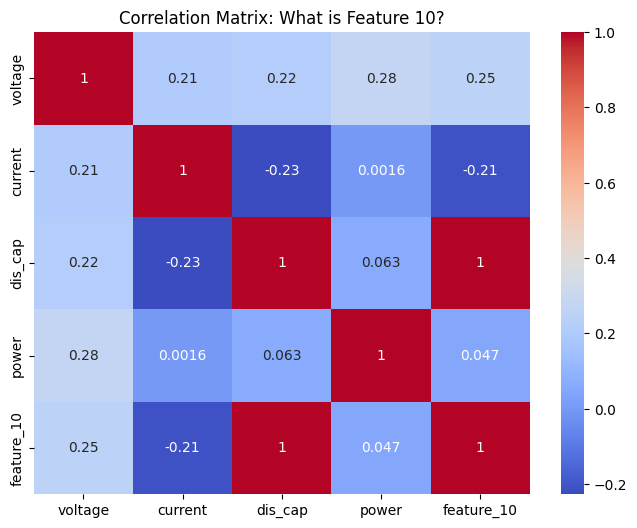

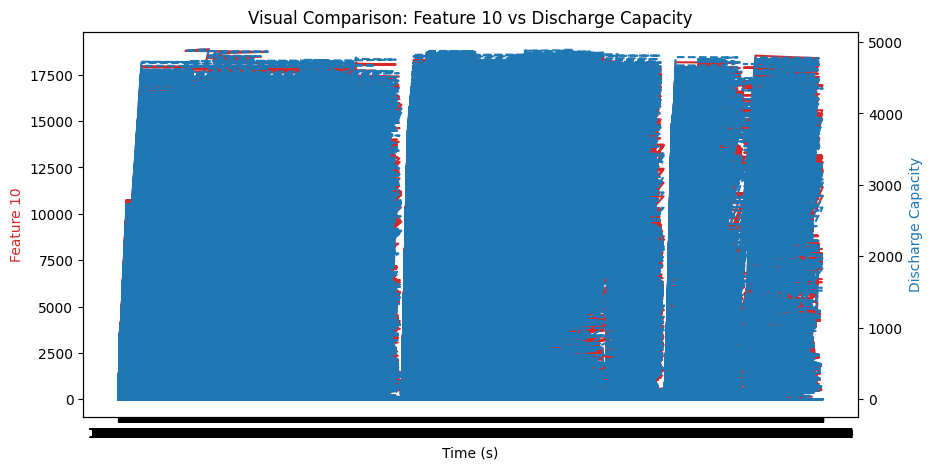

--- Training Model for 1 ---
--- Model Performance ---
RMSE: 0.3575
MAE:  0.3575
MAPE: 41.6754

Processing 2 (10 files)...
--- Training Model for 2 ---
--- Model Performance ---
RMSE: 0.3842
MAE:  0.3842
MAPE: 11.2477

Processing 3 (10 files)...
--- Training Model for 3 ---
--- Model Performance ---
RMSE: 0.2137
MAE:  0.1822
MAPE: 26.5763

--- Running Comparative Analysis (Objective 2) ---


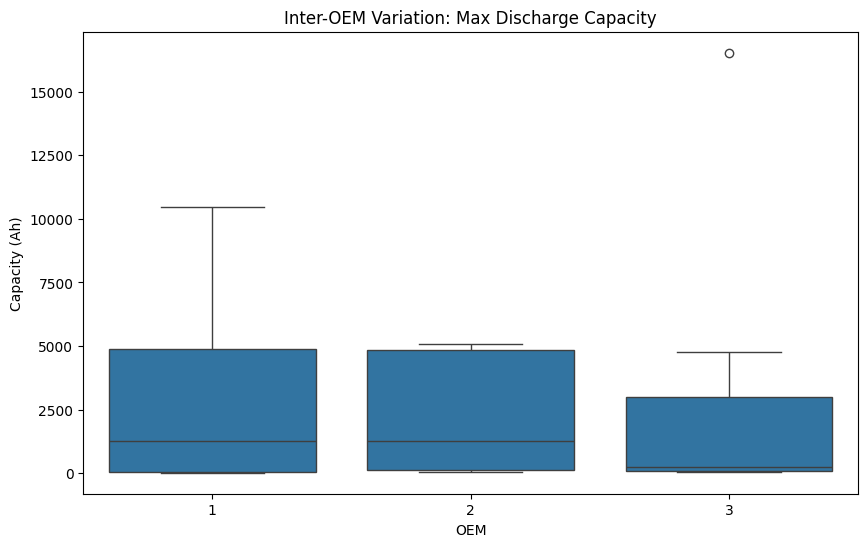

In [ ]:

import os
import glob
import pandas as pd

base_path = r'C:\Users\Aastik Wagadre\Downloads\Assignment Data-20251127T135657Z-1-001'


all_txt_files = glob.glob(os.path.join(base_path, "**", "*.txt"), recursive=True)

print(f"Total .txt files found: {len(all_txt_files)}")

if len(all_txt_files) == 0:
    print("ERROR: Still no files found. Please check if the zip file is actually extracted.")
else:

    files_by_oem = {}
    for f in all_txt_files:

        parent_folder = os.path.dirname(f)
        oem_name = os.path.basename(parent_folder)
        
        if oem_name not in files_by_oem:
            files_by_oem[oem_name] = []
        files_by_oem[oem_name].append(f)
        
    print(f"Identified OEMs: {list(files_by_oem.keys())}")


    data_store = {}
    
    for oem_name, file_list in files_by_oem.items():
        print(f"\nProcessing {oem_name} ({len(file_list)} files)...")
        

        df_list = []
        for filename in file_list:
            try:
                temp_df = pd.read_csv(filename, sep='\s+', names=COL_NAMES, header=None)

                temp_df['source_file'] = os.path.basename(filename)
                df_list.append(temp_df)
            except Exception as e:
                pass # Skip bad files
        
        if not df_list:
            continue
            
        df = pd.concat(df_list, ignore_index=True)
        data_store[oem_name] = df
 
        if len(data_store) == 1:
            print(f"--- Analyzing Feature 10 for {oem_name} ---")
            analyze_feature_10(df)

        est_rated_capacity = df['dis_cap'].max()
        est_rated_power = df['power'].max()
        
        print(f"--- Training Model for {oem_name} ---")

        X, y_soh, y_sop = feature_engineering(df, est_rated_capacity, est_rated_power)
        

        train_and_evaluate(X, y_soh)

    if len(data_store) > 1:
        print("\n--- Running Comparative Analysis (Objective 2) ---")
        compare_oems(data_store)
    else:
        print("\nOnly one OEM found; skipping comparison plot.")